# Evaluation of Pre-Trained Object Detection Models for on Data for different Driving Condititions

**Authors:** Kevin Okiah,  Ramesh Simhambhatla, Shravan  Kuchkula,

**Date:** 01/03/2019

**Organization:** DataScience@SMU Capstone



**Abstract:** Transfer learning (to be updated)

**References:** 
1. The code is adopted and modified from tensorflow modelzoo link  below https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md
2. **Dataset:**

In [1]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile
import pandas as pd
from PIL import Image
import cv2
import pandas as pd
from distutils.version import StrictVersion
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
import time

import os


#!pip install unipath

from unipath import Path

ObjectDetectionDirPath = Path(os.getcwd())

ResearchFolderPath = Path(ObjectDetectionDirPath.parent).parent # this id need to import object detection utils below if not working from its directory
#sys.path.append("..")  # This is needed since the notebook is stored in the object_detection folder.
sys.path.append(ResearchFolderPath)  # update this to tensorflow research directory

from object_detection.utils import ops as utils_ops

if StrictVersion(tf.__version__) < StrictVersion('1.9.0'):
    raise ImportError('Please upgrade your TensorFlow installation to v1.9.* or later!')


In [2]:
# This is needed to display the images.
%matplotlib inline

In [3]:
### check if GPU exists

In [4]:
from tensorflow.python.client import device_lib

In [5]:
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 12912725823124192143, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 2676948992
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 10235733568304444465
 physical_device_desc: "device: 0, name: GeForce GTX 1060 3GB, pci bus id: 0000:01:00.0, compute capability: 6.1"]

In [6]:
#from utils import label_map_util
from object_detection.utils import label_map_util

from object_detection.utils import visualization_utils as vis_util

In [7]:
# What model to download.
#https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md
myModels = ['faster_rcnn_inception_v2_coco','faster_rcnn_resnet50_coco','ssd_inception_v2_coco','rfcn_resnet101_coco', 
            'mask_rcnn_inception_v2_coco']#,'mask_rcnn_resnet101_atrous_coco'] #'faster_rcnn_inception_v2_coco',
#myModels =[]
# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join(ObjectDetectionDirPath.parent, 'data/mscoco_label_map.pbtxt')

category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

# Dowload and load frozen model
def Download_and_loadFrozen_model(current_model = myModels[0]):
    MODEL_NAME = current_model+'_2018_01_28'
    MODEL_FILE = MODEL_NAME + '.tar.gz'
    DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

    # Path to frozen detection graph. This is the actual model that is used for the object detection.
    PATH_TO_FROZEN_GRAPH = MODEL_NAME + '/frozen_inference_graph.pb'

    #download model
    opener = urllib.request.URLopener()
    opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)
    tar_file = tarfile.open(MODEL_FILE)
    for file in tar_file.getmembers():
      file_name = os.path.basename(file.name)
      if 'frozen_inference_graph.pb' in file_name:
        tar_file.extract(file, os.getcwd())
    print(current_model + " model has been downloaded...") 

def LoadFrozenModel(current_model = myModels[0]):
    MODEL_NAME = current_model+'_2018_01_28'
    # Path to frozen detection graph. This is the actual model that is used for the object detection.
    PATH_TO_FROZEN_GRAPH = MODEL_NAME + '/frozen_inference_graph.pb'
    #load frozen model
    detection_graph = tf.Graph()
    with detection_graph.as_default():
      od_graph_def = tf.GraphDef()
      with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')
    #print(current_model+" model loaded...")
    return detection_graph
    



In [8]:
coco_labels = pd.DataFrame(category_index).T

coco_labels.to_csv("coco_object_labels.csv")

In [9]:
# Commect this section out if you want to download models passed from the Download_and_loadFrozen_model list above
#for i in myModels:
#    #download and load a frozen model
#    detection_graph =Download_and_loadFrozen_model(i) #You can pass model name here

### Inference and  Object Detection

In [10]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

In [11]:
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    #############################################
    # Comment this code out if you don't have a GPU
    #############################################
    #with tf.device('/device:GPU:0'):
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict

In [12]:
import os
# Size, in inches, of the output images.
IMAGE_SIZE = (20, 10)

In [13]:
def InferNowXXX(modelName =myModels[0], detection_graph=LoadFrozenModel()):
    Temp = pd.DataFrame()
    dataX = pd.DataFrame()
    result = pd.DataFrame()
    #folders = ['samples-1k/Driving_condition/dayX/']#,'samples-1k/Driving_condition/night', 'samples-1k/Driving_condition/Snowy']
    #condition = ['dayX']#, 'Night', 'Snowy']
    for i in range(0,len(folders)):
        Imageslist = os.listdir(folders[i]+'images')
        Imageslist.sort()

        PATH_TO_TEST_IMAGES_DIR =folders[i]+'images'
        imagePATH = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, Imageslist[j]) for j in range(0,len(Imageslist)) ]

        for image_path in imagePATH:

            image = Image.open(image_path)
            width, height = image.size
            # the array based representation of the image will be used later in order to prepare the
            # result image with boxes and labels on it.
            image_np = load_image_into_numpy_array(image)
            # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
            image_np_expanded = np.expand_dims(image_np, axis=0) 
            # Actual detection.
            t0 = time.time()
            output_dict =run_inference_for_single_image(image_np, detection_graph)
            t1 = time.time()
            total = t1-t0
            t0 =t1=0
            # Visualization of the results of a detection.
            vis_util.visualize_boxes_and_labels_on_image_array(
               image_np,
               output_dict['detection_boxes'],
               output_dict['detection_classes'],
               output_dict['detection_scores'],
               category_index,
               instance_masks=output_dict.get('detection_masks'),
               use_normalized_coordinates=True, #
               line_thickness=2)
            #plt.figure(figsize=IMAGE_SIZE)
            #plt.imshow(image_np)
            #plt.title(modelName)
            #df = pd.DataFrame([[modelName, total, condition[i], image_path]], columns=['Model','Inference Time (Sec)','Driving Condition', 'ImageID'])
            
            print(image_path.split('/')[4], ": ", modelName, ":", round(total, 3), "Seconds")
            #print(output_dict['detection_classes'],output_dict['detection_scores'])
            detection_classes = pd.DataFrame(output_dict['detection_classes'])
            detection_scores = pd.DataFrame(output_dict['detection_scores'])
            detection_boxes  = pd.DataFrame(output_dict['detection_boxes'])
            #<class_name> <confidence> <left> <top> <right> <bottom>
            #dataX["Class"] = detection_classes
            #pd.concat([df1, df3], join="inner")
            result = pd.concat([detection_classes, detection_scores], axis=1, sort=False)
            result = pd.concat([result, detection_boxes], axis=1, sort=False)
            #the code below was the bug
            result.columns = ['Class', 'Confidence','top', 'left', 'bottom', 'right'] #updated
            result['Width'] =width
            result['Height'] =height
            result['Model']= modelName
            result['Inference Time (Sec)']= total
            result['Driving Condition'] = condition[i]
            result['ImageID'] = image_path.split('/')[4]
            Temp = Temp.append(result)
            #print(str(output_dict))
    return(Temp)

In [14]:
def Run_inference():
    temp = pd.DataFrame()
    for i in myModels:
        print("**********************************************************")
        print("*   Inferring with...: ", i,'   *')
        print("**********************************************************")
        detgraph = LoadFrozenModel(i)
        #detection_graph =Download_and_loadFrozen_model(i) #You can pass model name here
        temp = temp.append(InferNowXXX(i, detgraph))
        #InferNow(i, detgraph)
    print("******************************************")
    temp = temp[temp.Confidence != 0]
    temp.to_csv('InferenceData.csv', index=False)
    temp = pd.read_csv('InferenceData.csv')


## Generate Predict Labels txt files

In [15]:
# Generate predicted labels. txt file
# https://github.com/Cartucho/mAP#create-the-ground-truth-files
# This Code block generates predictions files which take the format below for indivisual images. 
# <class_name> <confidence> <left> <top> <right> <bottom>

def PredictionsFiles():
    temp = pd.DataFrame()
    temp = pd.read_csv('InferenceData.csv')
    #temp = tempX[tempX.Confidence != 0]
    models = pd.unique(temp['Model'])
    Drivingcondition = pd.unique(temp['Driving Condition'])
    col_list = ['Class', 'Confidence', 'left', 'top', 'right', 'bottom'] # updated

    for i in models:
        ModelData = temp[temp['Model']==i]  #subset data by model
        #display(ModelData)
        for j in Drivingcondition:
            #print(j)
            DrivingConditionData = ModelData[ModelData['Driving Condition']==j] #subset data by driving conditon
            #print(DrivingConditionData.shape)
            templist =pd.unique(DrivingConditionData['ImageID'])
            #print(len(templist))
            for k in templist:
                ImageData = DrivingConditionData[DrivingConditionData['ImageID']==k]

                mod=list(pd.unique(ImageData.Model))[0]# model
                weather =list(pd.unique(ImageData['Driving Condition']))[0]#driving Condition
                #weather = "Day1"
                pic = list(pd.unique(ImageData.ImageID))[0].split('.')[0] #image
                directory ="samples-1k/Driving_condition/"+weather+"/predicted/"+mod+"/"
                #create the directory if it doesn't exist
                import os, errno
                try:
                    os.makedirs(directory)
                except OSError as e:
                    if e.errno != errno.EEXIST:
                        raise
                #save_address ="/sample-1k/Driving_condition/Predictions/"+mod+"/"+weather+"/"+pic+".txt" #prediction file
                ImageData[col_list].to_csv(directory+pic+".txt", header=None, index=None, sep=' ')

## Generate Groundtruth Files

In [16]:
import os
import glob
import pandas as pd
import xml.etree.ElementTree as ET

In [17]:
# this function takes in folder with ground truth xml files and returns the data in a dataframe
def xml_to_csv(path):
    xml_list = []
    for xml_file in glob.glob(path + '/*.xml'):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for member in root.findall('object'):
            value = (root.find('filename').text,
                     int(root.find('size')[0].text),
                     int(root.find('size')[1].text),
                     member[0].text,
                     int(member[4][0].text),
                     int(member[4][1].text),
                     int(member[4][2].text),
                     int(member[4][3].text)
                     )
            xml_list.append(value)
    column_name = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    classes = pd.read_csv('coco_object_labels.csv')
    classid =[]
    # add class id from the coco labels
    for i in list(xml_df['class']):
        #print([int(classes[classes.name==i].id))
        temp = [int(classes[classes.name==i].id)]
        #print(temp)
        classid =classid+temp

    xml_df['id'] =classid 
    #print(pd.unique(list(xml_df['class'])))
    # scaling the x and y coordinates for the ground truth file by the image dimensions
    xml_df["xmin_scaled"] = xml_df.xmin/xml_df.width
    xml_df["ymin_scaled"] = xml_df.ymin/xml_df.height
    xml_df["xmax_scaled"] = xml_df.xmax/xml_df.width
    xml_df["ymax_scaled"] = xml_df.ymax/xml_df.height
    return xml_df

#image_path = os.path.join(os.getcwd(), folders[0]+'/ground-truth-xml')
#GroundTruth = xml_to_csv(image_path)

In [18]:
#GroundTruth

In [19]:
# https://github.com/Cartucho/mAP#create-the-ground-truth-files
# This Code block generates predictions files which take the format below for indivisual images. 
# <class_name> <confidence> <left> <top> <right> <bottom>

def GroundTruth2txt(GroundTruth,folder= "samples-1k/Driving_condition/day"):
    directory = folder+'/ground-truth/'
    temp = pd.DataFrame(GroundTruth.copy())
    #temp = tempX[tempX.Confidence != 0]
    imageslist = pd.unique(temp['filename']) #unique images
    col_list = ['id', 'xmin_scaled', 'ymin_scaled','xmax_scaled','ymax_scaled'] # updated
    print(directory)

    for i in imageslist:
        imageData = temp[temp['filename']==i]  #subset data by image
        x = i.split('.jpg')
        if len(x)>1:
            filename = i.split('.jpg')[0]+'.txt' #get the ground truth filename
        else:
            filename = i.split('.JPG')[0]+'.txt' #get the ground truth filename   
        
        import os, errno
        try:
            os.makedirs(directory)
        except OSError as e:
            if e.errno != errno.EEXIST:
                raise
        imageData[col_list].to_csv(directory+filename, header=None, index=None, sep=' ')

In [20]:
###################################################################
# This is the main function. runs all the functions in notebook   #
###################################################################

folders = ['samples-1k/Driving_condition/day/','samples-1k/Driving_condition/rainy/','samples-1k/Driving_condition/night/','samples-1k/Driving_condition/snowy/']
condition =['day','rainy','night', 'snowy'] 

def main(folder =folders[0]):
    #Run_inference()# Run Inferrence
    #PredictionsFiles()
    image_path = os.path.join(os.getcwd(), folder+'/ground-truth-xml')
    GroundTruth = xml_to_csv(image_path)
    foldername = str(folder.split('/')[2])
    GroundTruth.to_csv(folder+'/'+foldername+'_groundTruthlabels.csv', index=None)
    print('Successfully converted groundtruth xml to txt. You are ready to run mAP')
    #print(folder+'/'+foldername+'_groundTruthlabels.csv')
    GroundTruth2txt(GroundTruth, folder) #

########################    
for i in folders:
    main(i)
    print('############# Completed Processing   ##############: ' , i)

Successfully converted groundtruth xml to txt. You are ready to run mAP
samples-1k/Driving_condition/day//ground-truth/
############# Completed Processing   ##############:  samples-1k/Driving_condition/day/
Successfully converted groundtruth xml to txt. You are ready to run mAP
samples-1k/Driving_condition/rainy//ground-truth/
############# Completed Processing   ##############:  samples-1k/Driving_condition/rainy/
Successfully converted groundtruth xml to txt. You are ready to run mAP
samples-1k/Driving_condition/night//ground-truth/
############# Completed Processing   ##############:  samples-1k/Driving_condition/night/
Successfully converted groundtruth xml to txt. You are ready to run mAP
samples-1k/Driving_condition/snowy//ground-truth/
############# Completed Processing   ##############:  samples-1k/Driving_condition/snowy/


### Display Sample Predict and groundtruth bounding Boxes

In [21]:
from  DrawingBoundingBoxes import run

RED -> Predicted
GREEN -> Ground Truth
720


720


720


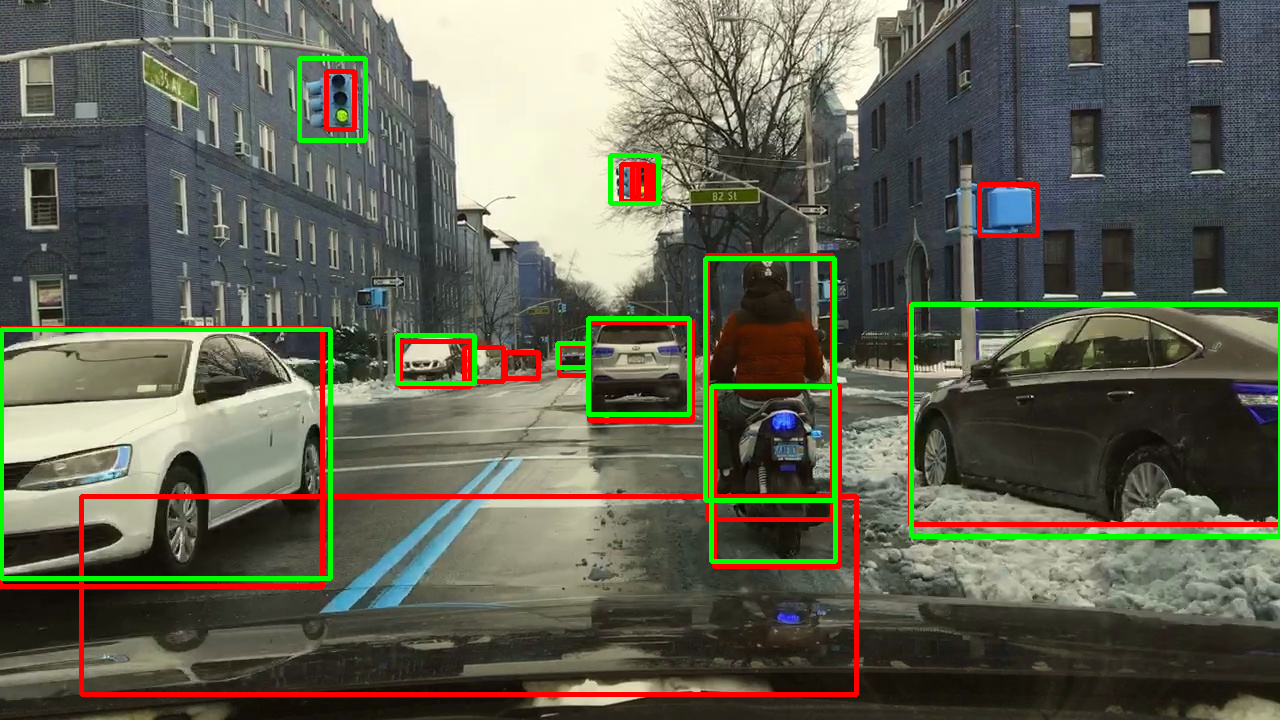

In [23]:
path = "samples-1k/Driving_condition/snowy"
run(path, 3) #folder and number of images to display bounding Boxes

## mAP Summary

In [24]:
import os, errno

In [25]:
rootwd=os.getcwd()

In [26]:
for i in folders:
    os.chdir(rootwd+'/'+i)
    %run './mAP_01222019.ipynb'
os.chdir(rootwd)

Workind Directory:  /home/kevimwe/tensorflow/models/research/object_detection/CapstoneA/samples-1k/Driving_condition/day


/home/kevimwe/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


mAP calculations Complete.....
Workind Directory:  /home/kevimwe/tensorflow/models/research/object_detection/CapstoneA/samples-1k/Driving_condition/rainy
mAP calculations Complete.....
Workind Directory:  /home/kevimwe/tensorflow/models/research/object_detection/CapstoneA/samples-1k/Driving_condition/night
mAP calculations Complete.....
Workind Directory:  /home/kevimwe/tensorflow/models/research/object_detection/CapstoneA/samples-1k/Driving_condition/snowy
mAP calculations Complete.....


In [27]:
mAP_Summary =pd.DataFrame()
# read in mAP summaries from the respective folders
for i in folders:
    Temp = pd.read_csv(i+'mAP_summary.csv')
    Temp = Temp.drop(['Unnamed: 0'], axis =1)
    mAP_Summary =mAP_Summary.append(Temp)
mAP_Summary=mAP_Summary.sort_values(['mAP'])

In [28]:
plt.style.use("classic")
import seaborn as sns
%matplotlib inline
sns.set(font_scale=1.5)

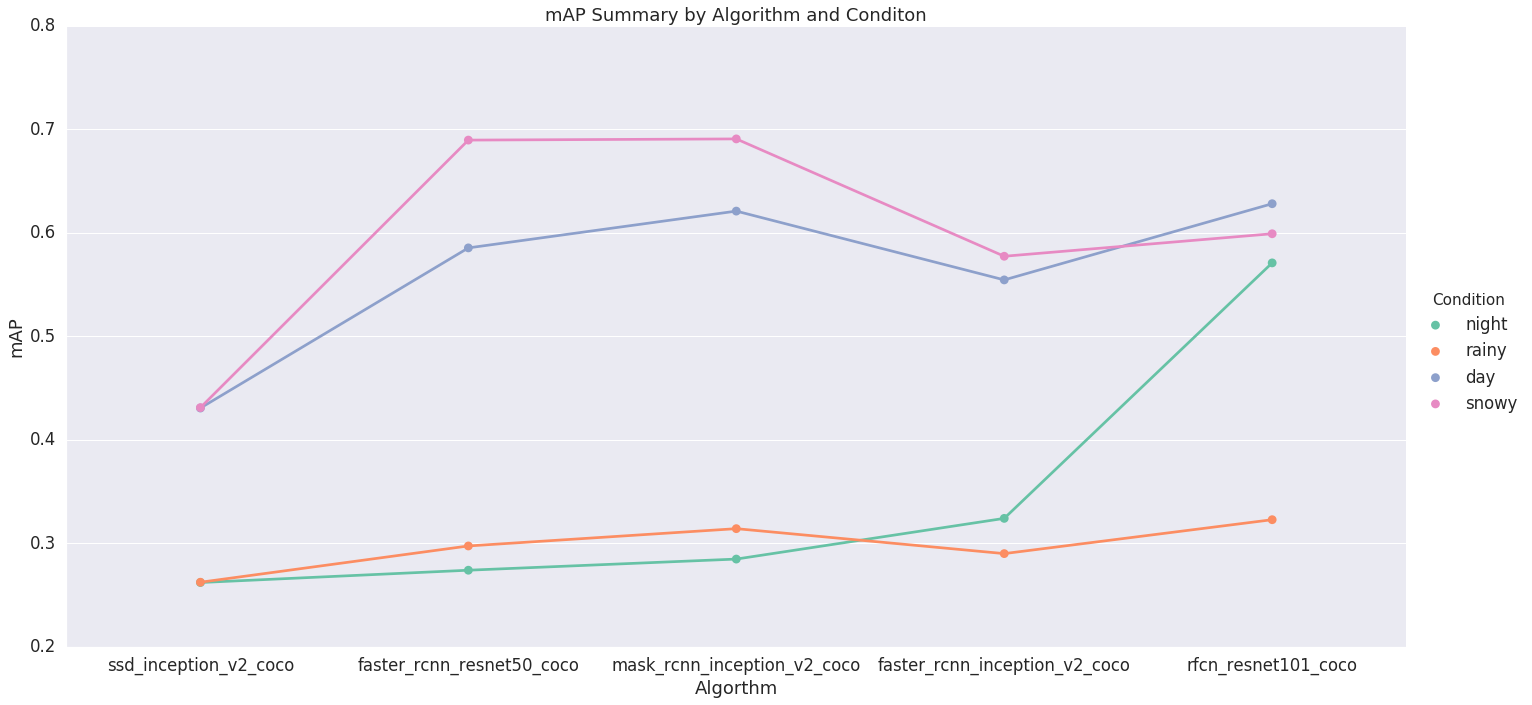

In [29]:
with sns.axes_style("darkgrid"):
    sns.catplot('Algorthm','mAP',data=mAP_Summary,  hue='Condition', kind="point", height=10, 
                aspect=2, palette="Set2")
    plt.title('mAP Summary by Algorithm and Conditon')


### AP for individual classes

## Visualize Inference Time Data

In [28]:
temp = pd.read_csv('InferenceData.csv')

In [29]:
## Summary Statistics
grouped =temp.groupby(['Model', 'Driving Condition'], as_index=False).agg({"Inference Time (Sec)": [min,max,'mean']})
grouped.columns = ["_".join(x) for x in grouped.columns.ravel()]
grouped

Model_ Driving Condition_  \
0   faster_rcnn_inception_v2_coco                day   
1   faster_rcnn_inception_v2_coco              night   
2   faster_rcnn_inception_v2_coco              rainy   
3   faster_rcnn_inception_v2_coco              snowy   
4       faster_rcnn_resnet50_coco                day   
5       faster_rcnn_resnet50_coco              night   
6       faster_rcnn_resnet50_coco              rainy   
7       faster_rcnn_resnet50_coco              snowy   
8     mask_rcnn_inception_v2_coco                day   
9     mask_rcnn_inception_v2_coco              night   
10    mask_rcnn_inception_v2_coco              rainy   
11    mask_rcnn_inception_v2_coco              snowy   
12            rfcn_resnet101_coco                day   
13            rfcn_resnet101_coco              night   
14            rfcn_resnet101_coco              rainy   
15            rfcn_resnet101_coco              snowy   
16          ssd_inception_v2_coco                day   
17          ssd_inception_v2_coco              night   
18          ssd_inception_v2_coco              rainy   
19          ssd_inception_v2_coco              snowy   

    Inference Time (Sec)_min  Inference Time (Sec)_max  \
0                   3.579987                  3.786316   
1                   3.390331                  3.501143   
2                   3.382345                  3.718910   
3                   3.390812                  3.490069   
4                   3.917908                  4.116710   
5                   3.940203                  4.119921   
6                   3.929049                  4.091520   
7                   3.921465                  4.261888   
8                   3.798207                  4.189118   
9                   4.064389                  4.412870   
10                  3.985585                  4.285964   
11                  4.200851                  4.471937   
12                  6.095284                  6.538813   
13                  6.149072                  6.933063   
14                  6.129479                  6.906126   
15                  5.910958                  6.625259   
16                  2.669600                  2.941768   
17                  2.683150                  3.003332   
18                  2.680692                  2.799436   
19                  2.711395                  2.838334   

    Inference Time (Sec)_mean  
0                    3.677998  
1                    3.435833  
2                    3.484306  
3                    3.428105  
4                    4.022783  
5                    4.038003  
6                    4.018905  
7                    4.041678  
8                    3.961045  
9                    4.159394  
10                   4.086500  
11                   4.306978  
12                   6.336825  
13                   6.555696  
14                   6.530144  
15                   6.195432  
16                   2.734416  
17                   2.759877  
18                   2.731712  
19                   2.760969

/home/kevimwe/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Model Inference Time Comparison')

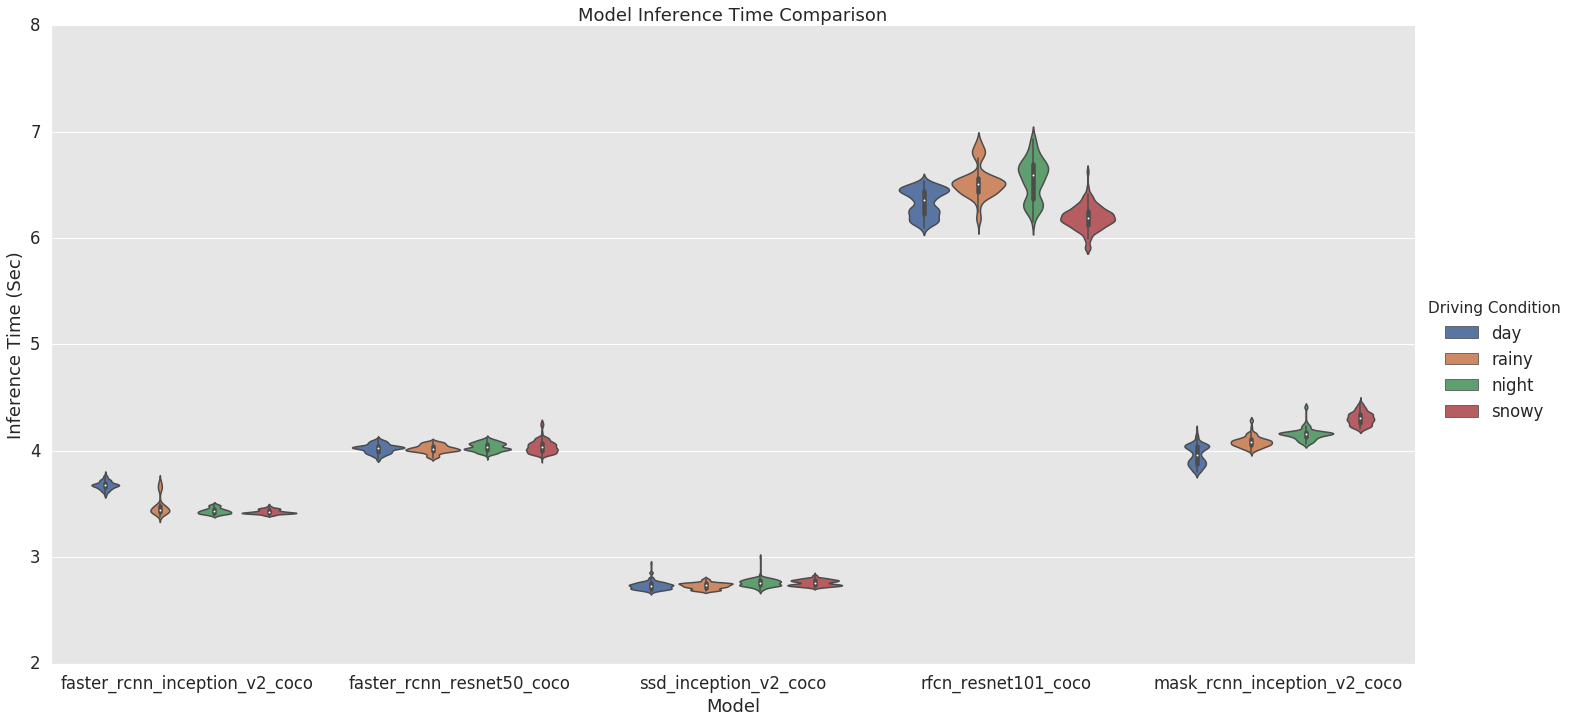

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline  

sns.set_style("darkgrid", {"axes.facecolor": ".9"})
df = temp.copy()
g = sns.catplot(x="Model", y="Inference Time (Sec)",
               hue="Driving Condition",# row="Driving Condition",
               data=df, kind="violin",
               height=10, aspect=2)
plt.title("Model Inference Time Comparison")

###   Berkeley Dataset download

http://dl.yf.io/bdd-data/v1/videos/

import zipfile, urllib.request, shutil

url = 'http://dl.yf.io/bdd-data/v1/videos/val.zip'
file_name = 'val.zip'

with urllib.request.urlopen(url) as response, open(file_name, 'wb') as out_file:
    shutil.copyfileobj(response, out_file)


In [ ]:
with zipfile.ZipFile(file_name) as zf:
    zf.extractall()